# Enumerate model solution space

This notebook loads the levers data and model, and tries to enumerate all the solutions in the solution space (i.e. all combinations of lever settings).

In [1]:
import numpy as np
import logging
import re
import pandas as pd
import json

In [2]:
%load_ext autoreload
%autoreload 2

## Define levers

Load from `levels.xlsx`

In [3]:
from load_levers import read_levers
levers = read_levers("levers.xlsx")

/Users/rcl38/work/cthru/global-petrochemicals-calculator/model/load_levers.py:158: FutureWarning: Possible nested set at position 6
  param = re.sub(r"^(.+)[[](.+)[]]$", r"\1__\2", param)


## Model

In [4]:
import load_model
model_data = load_model.load_model()

Loading RDF data...
 done


In [5]:
model, recipe_data = load_model.build_model(model_data)
other_results = load_model.define_model(model, recipe_data, levers)

['HDPEPolyethylene', 'LDPEPolyethylene', 'LLDPE', 'PPPolypropylene', 'PSPolystyrene', 'PVCPolyvinylChloride', 'PETPolyethyleneTerephthalatePolyesters', 'Polyurethane', 'SyntheticRubbers', 'FibrePPA', 'OtherPolymers']
['PolymerisationOfHDPE', 'PolymerisationOfLDPE', 'PolymerisationOfLLDPE', 'PolymerisationOfPP', 'PolymerisationOfPolystyrene', 'PolymerisationOfPVC', 'PolymerisationOfPET', 'PolymerisationOfPUR', 'PolymerisationOfStyreneButadiene', 'PolymerisationOfFibrePPA', 'PolymerisationOfOtherPolymers']
HDPEPolyethylene PolymerisationOfHDPE
LDPEPolyethylene PolymerisationOfLDPE
LLDPE PolymerisationOfLLDPE
PPPolypropylene PolymerisationOfPP
PSPolystyrene PolymerisationOfPolystyrene
PVCPolyvinylChloride PolymerisationOfPVC
PETPolyethyleneTerephthalatePolyesters PolymerisationOfPET
Polyurethane PolymerisationOfPUR
SyntheticRubbers PolymerisationOfStyreneButadiene
FibrePPA PolymerisationOfFibrePPA
OtherPolymers PolymerisationOfOtherPolymers


In [6]:
flows_sym = model.to_flows(recipe_data, flow_ids=True)
func = model.lambdify(recipe_data)
func_other = model.lambdify(data=recipe_data, expressions=other_results)

# Use lever levels to get test parameter settings

If we want to see what the model output looks like for specific lever settings, use them here to find the parameter settings that can go into the model.

This duplicates the logic that is built into the interactive calculator app, which does this to re-run the model every time the levers are changed.

**TODO**: interpolate product demand between the levels to get smoother results, maybe delete the extra demand for simplicity

In [7]:
def get_model_output(lever_settings, time_index):
    params = levers.get_params(lever_settings, time_index=time_index)
    result = func_other(params)
    return result

In [8]:
baseline = {lever.lever_id: lever.levels[0].level_id for lever in levers.levers}
get_model_output(baseline, 0)

{'Production_polymers_virgin': 379373059.0043249,
 'Production_polymers_recycled': 15308988.171548283,
 'ElecReq_green_hydrogen': 0.0,
 'NGReq_green_hydrogen': 0.0,
 'ElecReq_other_hydrogen': 3055613067.963296,
 'NGReq_other_hydrogen': 190975816.747706,
 'ElecReq_biomass': 337644532.1846393,
 'NGReq_biomass': 2793201197.129108,
 'ElecReq_primary_production': 147976630217.16284,
 'NGReq_primary_production': 5170312115678.016,
 'ElecReq_organic_synthesis': 47568363115.25831,
 'NGReq_organic_synthesis': 2548168907695.5747,
 'ElecReq_downstream': 150967722613.6118,
 'NGReq_downstream': 575572627673.8623,
 'ElecReq_end_of_life': 3061797634.3096566,
 'NGReq_end_of_life': 0.0,
 'ElecReq_other': 0,
 'NGReq_other': 0,
 'ElecReq': 352967771180.49036,
 'NGReq': 8297037828061.328,
 'CCS': -0.00018310546875,
 'Emissions_ElecReq_green_hydrogen': 0.0,
 'Emissions_NGReq_green_hydrogen': 0.0,
 'Emissions_ElecReq_other_hydrogen': 1687309536.129332,
 'Emissions_NGReq_other_hydrogen': 9376912.602312364,
 

## Enumerate all lever settings

In [ ]:
def enumerate_lever_settings(levers):
    if not levers:
        yield {}
        return
    next_lever = levers[0]
    rest_levers = levers[1:]
    for level in next_lever.levels:
        for settings in enumerate_lever_settings(rest_levers):
            yield {**settings, next_lever.lever_id: level.level_id}
        

In [ ]:
len([lever for lever in levers.levers if len(lever.levels) > 1])

How many combinations do we expect?

In [ ]:
n_combinations = np.product([min(5, len(lever.levels)) for lever in levers.levers])
print(f"{n_combinations/1e6:.0f} million combinations")

In [ ]:
test_params = levers.get_params(baseline, time_index=6)

In [ ]:
%%timeit
func_other(test_params)

In [ ]:
%%timeit
get_model_output(baseline, 6)

Approx 4832 million combinations, approx 6 ms/results, makes:

In [ ]:
print(f"{4830e6 * 6e-3 / 60 / 60 / 24} days")

In [ ]:
print(f"{1e6 * 6e-3 / 60 / 60} hours")

In [ ]:
# results = pd.DataFrame([
#     {**settings, **get_model_output({**baseline, **settings}, time_index=6)}
#     for settings in enumerate_lever_settings(levers.levers[:])
# ])

In [18]:
#results = pd.read_csv("enumerated_results_6.csv", index_col=list(range(len(baseline))))
results = pd.read_parquet(f"enumerated_results_6.parquet")#, columns=["GHG_total"])

In [19]:
results.iloc[0]

Production_polymers_virgin      5.925501e+08
Production_polymers_recycled    2.972320e+07
ElecReq_green_hydrogen          0.000000e+00
NGReq_green_hydrogen            0.000000e+00
ElecReq_other_hydrogen          4.665196e+09
                                    ...     
GHG_biomass                    -1.548458e+09
GHG_production                  3.013611e+12
GHG_use                         1.060171e+12
GHG_eol                         4.943561e+11
GHG_total                       4.566589e+12
Name: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), Length: 110, dtype: float64

Simple SA:
- Morris style effect of the change from level 1 to level 4 for each lever: lots of results for all the other permutations.
- Summarise in a histogram what the effect is
    - Some are always positive
    - Some, it depends, etc
    
    
?

In [20]:
def effect_calc(lever):
    levels = results.index.levels[results.index.names.index(lever)]
    a = results["GHG_total"].xs(levels[0], level=lever)
    b = results["GHG_total"].xs(levels[-1], level=lever)
    effect = (b - a) / 1e9  # Mt
    return {
        "whislo": effect.min(),
        "q1":  np.quantile(effect, 0.25),
        "med": np.quantile(effect, 0.50),
        "q3":  np.quantile(effect, 0.75),
        "whishi": effect.max(),
        "mu": effect.mean(),
        "mu_star": abs(effect).mean(),
        "sigma": effect.std(),
        "label": lever,
    }

In [21]:
lever_ids = [lever.lever_id for lever in levers.levers]
ee = pd.DataFrame({
    lever_id: effect_calc(lever_id)
    for lever_id in lever_ids
    # Don't include levers that only have one level
    if len(results.index.levels[results.index.names.index(lever_id)]) > 1
}).T

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

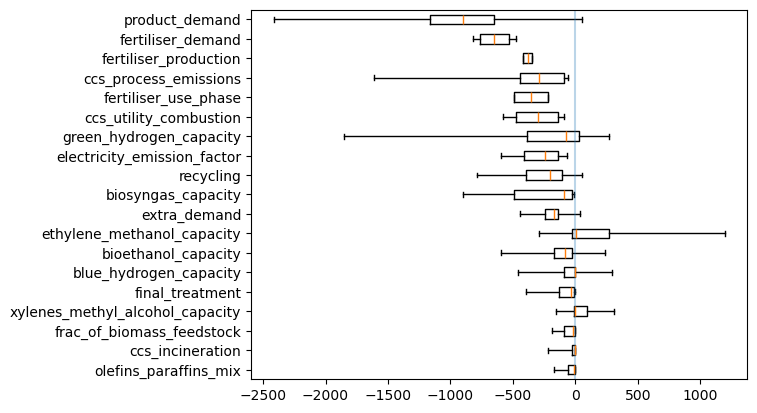

In [23]:
fig, ax = plt.subplots()
ee_sorted = ee.reset_index().sort_values("mu_star", ascending=True)
ax.bxp(ee_sorted.to_dict('records'), showfliers=False, vert=False);
ax.axvline(0, alpha=0.3);

In [24]:
# NB currently only have min/max levels
shape = [min(2, len(lever.levels)) for lever in levers.levers]

<Axes: >

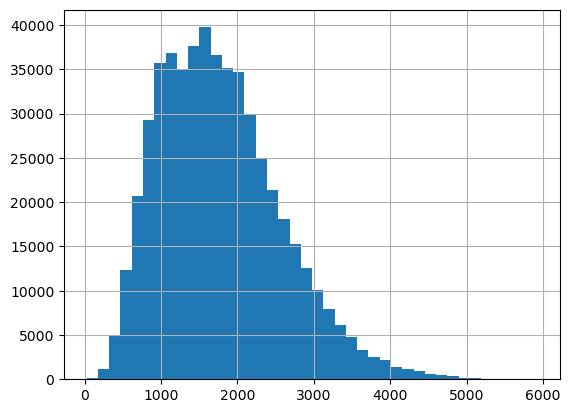

In [25]:
(results["GHG_total"] / 1e9).hist(bins=40)

In [26]:
GHG_total = results.reset_index()
GHG_total["class"] = "High"
GHG_total.loc[GHG_total["GHG_total"] < 0.3e12, "class"] = "Low"

In [27]:
threshold = 100

cols_low = GHG_total[GHG_total["GHG_total"] < (threshold * 1e9)].iloc[:, :len(levers.levers)]
cols_high = GHG_total[GHG_total["GHG_total"] >= (threshold * 1e9)].iloc[:, :len(levers.levers)]

for col in cols_low.columns:
    levels_low = cols_low[col].unique()
    levels_high = cols_high[col].unique()
    if len(levels_low) < len(levels_high):
        print(col)
        print("Low emissions:   ", levels_low)
        print("All combinations:", levels_high)
        print()

ccs_utility_combustion
Low emissions:    ['4']
All combinations: ['1' '4']

ccs_process_emissions
Low emissions:    ['4']
All combinations: ['1' '4']

blue_hydrogen_capacity
Low emissions:    ['1']
All combinations: ['1' '3']

green_hydrogen_capacity
Low emissions:    ['1']
All combinations: ['1' '4']

electricity_emission_factor
Low emissions:    ['4']
All combinations: ['1' '4']

biosyngas_capacity
Low emissions:    ['4']
All combinations: ['1' '4']

bioethanol_capacity
Low emissions:    ['4']
All combinations: ['1' '4']

extra_demand
Low emissions:    ['4']
All combinations: ['1' '4']

product_demand
Low emissions:    ['4']
All combinations: ['1' '4']

fertiliser_production
Low emissions:    ['4']
All combinations: ['1' '4']

fertiliser_use_phase
Low emissions:    ['2']
All combinations: ['1' '2']

fertiliser_demand
Low emissions:    ['3']
All combinations: ['1' '3']



In [28]:
results["GHG_total"].min() / 1e12

0.027032984920197838

In [29]:
results["GHG_total"].max() / 1e12

5.929948070474456

In [30]:
print("\n".join(results.columns))

Production_polymers_virgin
Production_polymers_recycled
ElecReq_green_hydrogen
NGReq_green_hydrogen
ElecReq_other_hydrogen
NGReq_other_hydrogen
ElecReq_biomass
NGReq_biomass
ElecReq_primary_production
NGReq_primary_production
ElecReq_organic_synthesis
NGReq_organic_synthesis
ElecReq_downstream
NGReq_downstream
ElecReq_end_of_life
NGReq_end_of_life
ElecReq_other
NGReq_other
ElecReq
NGReq
CCS
Emissions_ElecReq_green_hydrogen
Emissions_NGReq_green_hydrogen
Emissions_ElecReq_other_hydrogen
Emissions_NGReq_other_hydrogen
Emissions_ElecReq_biomass
Emissions_NGReq_biomass
Emissions_ElecReq_primary_production
Emissions_NGReq_primary_production
Emissions_ElecReq_organic_synthesis
Emissions_NGReq_organic_synthesis
Emissions_ElecReq_downstream
Emissions_NGReq_downstream
Emissions_ElecReq_end_of_life
Emissions_NGReq_end_of_life
Emissions_ElecReq_other
Emissions_NGReq_other
Emissions_ElecReq
Emissions_NGReq
Emissions_DirectProcess_CO2_green_hydrogen
Emissions_DirectProcess_CH4_green_hydrogen
Emissi

Variation in emissions factor with production quantity? Is it linear?

This is not an exact calculation of the emissions factor, which would require LCA calculation on top of the supply mixes from the mass flow model. But approximately.

In [69]:
results["Emissions_polymer_production"] = (
    results["EmissionsByStage_feedstocks"] +
    results["EmissionsByStage_hydrogen"] +
    results["EmissionsByStage_primary_production"] +
    results["EmissionsByStage_organic_synthesis"] +
    results["EmissionsByStage_downstream"] +
    results["EmissionsByStage_biomass"]
)
# Excluding biomass (-1) and end-of-life (+1)

In [78]:
results["Production_polymers_virgin_label"] = results["Production_polymers_virgin"].apply(lambda x: x/1e6) #f"{x/1e6:.0f} Mt")
results["Emissions_polymer_production_per_kg"] = results["Emissions_polymer_production"] / (1000 * results["Production_polymers_virgin"])

In [79]:
results_fewer = results.xs("1", level="extra_demand")

In [84]:
sns.set_style("darkgrid");

In [ ]:
plt.boxplot(

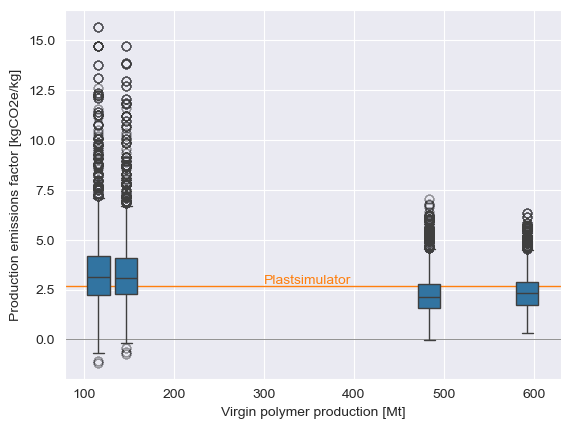

In [100]:
plt.axhline(0, color='k', lw=0.5, alpha=0.6);
plt.axhline(2.67, color='C1', lw=1);
plt.text(300, 2.8, "Plastsimulator", color='C1');
sns.boxplot(results_fewer, x="Production_polymers_virgin_label", y="Emissions_polymer_production_per_kg", native_scale=True, flierprops=dict(alpha=0.006));
plt.xlabel("Virgin polymer production [Mt]");
plt.ylabel("Production emissions factor [kgCO2e/kg]");

In [73]:
threshold = 15500

GHG_total = results_fewer.reset_index()

cols_low = GHG_total[GHG_total["Emissions_polymer_production_per_kg"] < (threshold)].iloc[:, :len(levers.levers)]
cols_high = GHG_total[GHG_total["Emissions_polymer_production_per_kg"] >= (threshold)].iloc[:, :len(levers.levers)]

for col in cols_low.columns:
    levels_low = cols_low[col].unique()
    levels_high = cols_high[col].unique()
    if len(levels_high) < len(levels_low):
        print(col)
        print("High emissions:   ", levels_high)
        print("All combinations:", levels_low)
        print()

ccs_utility_combustion
High emissions:    ['1']
All combinations: ['1' '4']

ccs_process_emissions
High emissions:    ['1']
All combinations: ['1' '4']

blue_hydrogen_capacity
High emissions:    ['1']
All combinations: ['1' '3']

green_hydrogen_capacity
High emissions:    ['1']
All combinations: ['1' '4']

electricity_emission_factor
High emissions:    ['1']
All combinations: ['1' '4']

biosyngas_capacity
High emissions:    ['1']
All combinations: ['1' '4']

bioethanol_capacity
High emissions:    ['1']
All combinations: ['1' '4']

xylenes_methyl_alcohol_capacity
High emissions:    ['4']
All combinations: ['1' '4']

ethylene_methanol_capacity
High emissions:    ['4']
All combinations: ['1' '4']

recycling
High emissions:    ['4']
All combinations: ['1' '4']

product_demand
High emissions:    ['4']
All combinations: ['1' '4']

Production_polymers_virgin
High emissions:    [1.16091676e+08]
All combinations: [5.92550122e+08 4.83546563e+08 1.46906727e+08 1.16091676e+08]



In [56]:
cols_high

,ccs_utility_combustion,ccs_process_emissions,ccs_incineration,olefins_paraffins_mix,blue_hydrogen_capacity,green_hydrogen_capacity,final_treatment_emission_factor,feedstock_emission_factor,natural_gas_emission_factor,electricity_emission_factor,...,bioethanol_capacity,xylenes_methyl_alcohol_capacity,ethylene_methanol_capacity,final_treatment,recycling,extra_demand,product_demand,fertiliser_production,fertiliser_use_phase,fertiliser_demand
44032,1,1,1,1,1,1,1,1,1,1,...,1,4,4,1,4,1,4,1,1,1
44036,1,1,4,1,1,1,1,1,1,1,...,1,4,4,1,4,1,4,1,1,1
44040,1,1,1,2,1,1,1,1,1,1,...,1,4,4,1,4,1,4,1,1,1
44044,1,1,4,2,1,1,1,1,1,1,...,1,4,4,1,4,1,4,1,1,1
44160,1,1,1,1,1,1,1,1,1,1,...,1,4,4,1,4,1,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506892,1,1,4,2,1,1,1,1,1,1,...,1,4,4,4,4,1,4,4,2,3
507008,1,1,1,1,1,1,1,1,1,1,...,1,4,4,4,4,1,4,4,2,3
507012,1,1,4,1,1,1,1,1,1,1,...,1,4,4,4,4,1,4,4,2,3
507016,1,1,1,2,1,1,1,1,1,1,...,1,4,4,4,4,1,4,4,2,3


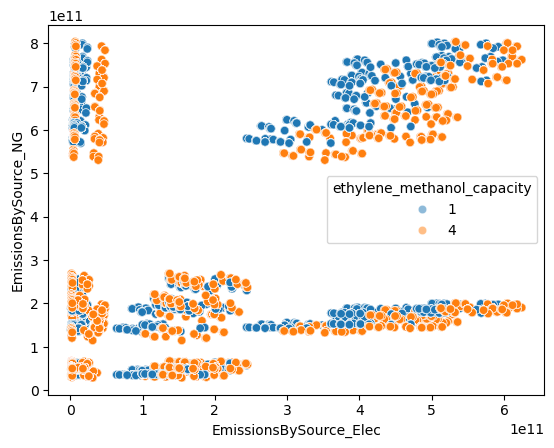

In [17]:
sns.scatterplot(results, x="EmissionsBySource_Elec", y="EmissionsBySource_NG", hue="ethylene_methanol_capacity", alpha=0.5);

In [ ]:
sns.scatterplot(results, x="ElecReq", y="NGReq", hue="ethylene_methanol_capacity", alpha=0.5);

In [ ]:
sns.scatterplot(results, x="ElecReq", y="NGReq", hue="product_demand", alpha=0.5);

In [ ]:
results["ambition"] = np.log(results[baseline.keys()].astype(int).product(axis=1))

In [ ]:
sns.scatterplot(results, x="ElecReq", y="NGReq", hue="ambition", alpha=0.5);

In [ ]:
years = list(range(2020, 2051, 5))
over_time = pd.DataFrame([
    pd.read_parquet(f"enumerated_results_{i}.parquet", columns=["GHG_total"])["GHG_total"]
    for i in range(7)
], index=years).T

In [ ]:
d = (over_time / 1e9).values.T
d.shape

In [ ]:
plt.plot(years, d[:, ::21], alpha=0.005, c='k');

In [ ]:
fig, ax = plt.subplots(1, 7, sharey=True, sharex=False)
bins = np.arange(0, 5, 0.1);
for i in range(7):
    ax[i].hist(d[i]/1000, bins=bins, orientation='horizontal', density=False)
    ax[i].set_frame_on(False)
    #ax[i].xaxis.set_visible(False)
    ax[i].set_xticks([])
    ax[i].set_xlabel(years[i])
    if i > 0:
        ax[i].yaxis.set_ticks_position("none")
    ax[i].plot(0, d[i, 0]/1000, 'ro', ms=8, clip_on=False);
    ax[i].axhline(0, c='k', lw=0.75);
ax[0].set_ylabel("Total GHG emissions [GtCO2e]");
ax[-1].annotate("Baseline", xy=(0, d[-1, 0]/1000), xytext=(8, 0), textcoords='offset points', c='r', va='center')

In [ ]:
over_time.iloc[0]

In [ ]:
axis = ax[0]
axis.

In [ ]:
x.set_ticks_position(